In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from playsound import playsound
import math
import sys
print(sys.version_info)
print('Python: '+sys.version)
print(sys.executable)
print('Tensorflow version: '+tf.__version__)
print('Keras version: '+keras.__version__)

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
Python: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
C:\Users\Stargazer\Anaconda3\envs\safeclone\python.exe
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa

In [5]:
import os
os.chdir('E:\JUPYTER_files')
os.path.dirname(sys.executable)

'C:\\Users\\Stargazer\\Anaconda3\\envs\\safeclone'

In [6]:
tf.compat.v1.enable_eager_execution()

In [7]:
# suppresses some error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [8]:
# early stopping callback

class EarlyStoppingAtMinLoss2(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=25): # set patience here
        super(EarlyStoppingAtMinLoss2, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [9]:
# prints the difference on loss and val_loss, though oftentimes it seems to not work properly

class DifferencePrint(keras.callbacks.Callback):    
    def __init__(self, lastloss = 0.0, lastacc = 0.0, currloss = 0.0, curracc = 0.0):
        super(DifferencePrint, self).__init__()
        self.lastloss = lastloss
        self.lastacc = lastacc
        self.currloss = currloss
        self.curracc = curracc
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            self.lastloss = float(logs["val_loss"])
            self.lastacc = float(logs["val_accuracy"])
        else:
            self.currloss = float(logs["val_loss"])
            self.currtacc = float(logs["val_accuracy"])
            print('\nVal_loss diff:', self.currloss - self.lastloss)
            print('Val_accuracy diff:', self.curracc - self.lastacc)
            self.lastloss = self.currloss
            self.lastacc = self.curracc

In [10]:
# logs network state to universal traning log csv on epoch end
class UniversalLog(keras.callbacks.Callback):
    def __init__(self):
        super(UniversalLog, self).__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        with open('universal training log.csv', 'a') as f:
            f.write('\nepoch: ' +str(epoch)+ ', t_loss: ' +str(logs["loss"])+ ', t_acc: ' +str(logs["accuracy"])+', v_loss: ' +str(logs["val_loss"])+', v_acc: ' +str(logs["val_accuracy"]))
            f.close()

In [11]:
# checkpoint creation callback

checkpoint_filepath = '/jupyter_files/checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [12]:
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime

In [13]:
# Determines whether to read the files with the padding before the data or after the data. 0/1
padding_after = 0

In [14]:
# reads float inputs (age and length of stay variables)
padding_extra = ''
if padding_after != 0:
    padding_extra = ' - padding after'

f = open('training data - inputs - float'+ padding_extra +'.txt','r')
float_inputs = []
temp = []
for line in f:
    if line == "*new timeseries*\n":
        float_inputs.append(temp)
        temp = []
    else:
        temp2 = list(line[1:-2].strip(' ').split(','))
        temp3 = []
        for x in temp2:
            temp3.append(float(x))
        temp.append(temp3)
print(len(float_inputs))
print(len(float_inputs[0]))
print(len(float_inputs[0][0]))

6871
41
2


In [15]:
# reads one-hot inputs (ethnicity and marital status variables)
f = open('training data - inputs - onehot.txt','r')
onehot_inputs = []
temp = []
for line in f:
    if line == "*new timeseries*\n":
        onehot_inputs.append(temp)
        temp = []
    else:
        temp2 = list(line[1:-2].strip(' ').split(','))
        temp3 = []
        for x in temp2:
            if int(x) == 0:
                temp3.append(False)
            elif int(x) == 1:
                temp3.append(True)
            else:
                print("ERROR... ERROR... ERROR... value:",x)
        temp.append(temp3)
print(len(onehot_inputs))
print(len(onehot_inputs[0]))
print(len(onehot_inputs[0][0]))

6871
41
17


In [16]:
# sets input length
float_input_length = len(float_inputs[0][0])
onehot_input_length = len(onehot_inputs[0][0])

In [17]:
# Determines what data aggregation we'll run the algorithm with. Can be 'categorical', '3digit', or '4digit'.
data_aggr = 'categorical'

In [18]:
# reads multi-hot ICD inputs
f = open('training data - inputs - '+ data_aggr + padding_extra +'.txt','r')
icd_inputs = []
temp = []
for line in f:
    if line == "*new timeseries*\n":
        icd_inputs.append(temp)
        temp = []
    else:
        temp2 = list(line[1:-2].strip(' ').split(','))
        temp3 = []
        for x in temp2:
            if int(x) == 0:
                temp3.append(False)
            elif int(x) == 1:
                temp3.append(True)
            else:
                print("ERROR... ERROR... ERROR... value:",x)
        temp.append(temp3)
print(len(icd_inputs))
print(len(icd_inputs[0]))
print(len(icd_inputs[0][0]))

6871
41
19


In [19]:
# reads multi-hot ICD inputs
f = open('training data - outputs - '+ data_aggr +'.txt','r')
icd_outputs = []
temp = []
for line in f:
    temp = []
    temp2 = list(line[1:-2].strip(' ').split(','))
    for x in temp2:
        if int(x) == 1:
            temp.append(True)
        elif int(x) == 0:
            temp.append(False)
        else:
            print("ERROR... ERROR... ERROR... value:",x)
    icd_outputs.append(temp)
print(len(icd_outputs))
print(len(icd_outputs[0]))
data_sample_size = len(icd_outputs)

6871
19


In [20]:
# Determines how much data to read from dataset   (default is 6871)
data_max_read = 6871

In [21]:
# RUN ONLY IN COMBINATION WITH DATA_MAX_READ. THIS IS TO CUT DATA, IT DOES NOT SHUFFLE. IT IS NOT NECESSARY, ONLY FOR TESTING.

real_data_read = 0
if data_max_read > len(icd_outputs) or data_max_read <= 1:
    real_data_read = len(icd_outputs)
else:
    real_data_read = data_max_read

float_inputs = float_inputs[:data_max_read]
onehot_inputs = onehot_inputs[:data_max_read]
icd_inputs = icd_inputs[:data_max_read]
icd_outputs = icd_outputs[:data_max_read]

In [22]:
#padding arrays
input_padding_icds = [[0 for i in range(len(icd_inputs[0][0]))] for j in range(len(icd_inputs[0]))]
input_padding_floats = [[0 for i in range(len(float_inputs[0][0]))] for j in range(len(float_inputs[0]))]
input_padding_onehot = [[0 for i in range(len(onehot_inputs[0][0]))] for j in range(len(onehot_inputs[0]))]
output_padding = [0 for i in range(len(icd_outputs[0]))]

In [23]:
# set batch size and testing unit split here. timesteps must be set to 41 as it is the max visit sequence length
timesteps = 41
"""
----------- HYPERPARAMETERS -----------
batch_size recommended values: (20,32,64,100)
testing_units recommended values: between 0.10 and 0.25
"""
batch_size = 20
testing_units = 0.10

In [24]:
input_ready_icds = icd_inputs
input_ready_floats = float_inputs
input_ready_onehot = onehot_inputs
output_ready_icds = icd_outputs

In [25]:
# adds padding to the timeseries sequencies
temp = 0
while temp < len(input_ready_icds):
    temp += batch_size
while len(input_ready_icds) < temp:
    input_ready_icds.append(input_padding_icds)
    
temp = 0
while temp < len(input_ready_floats):
    temp += batch_size
while len(input_ready_floats) < temp:
    input_ready_floats.append(input_padding_floats)
    
temp = 0
while temp < len(input_ready_onehot):
    temp += batch_size
while len(input_ready_onehot) < temp:
    input_ready_onehot.append(input_padding_onehot)
    
temp = 0
while temp < len(output_ready_icds):
    temp += batch_size
while len(output_ready_icds) < temp:
    output_ready_icds.append(output_padding)

input_ready_icds = np.asarray(input_ready_icds)
input_ready_floats = np.asarray(input_ready_floats)
input_ready_onehot = np.asarray(input_ready_onehot)
output_ready_icds = np.asarray(output_ready_icds)

In [26]:
icd_input_length = len(icd_inputs[0][0])
icd_output_length = len(icd_outputs[0])

In [27]:
# activation_function values are "sigmoid" or "softmax"
"""
----------- HYPERPARAMETERS -----------
output_activation recommended values: ("ReLU", "sigmoid", "softmax")
neuron count is dependent on problem complexity and therefore on data aggregation.
second layer count shouldn't be higher than first layer count. Also, min = 20, max = 250
"""
output_activation = "sigmoid"
first_layer_neurons = 150
second_layer_neurons = 150

In [28]:
# this is where our network is shaped
"""
----------- HYPERPARAMETERS -----------
hidden_layer_1 and _2 recommended values: (RNN,LSTM,GRU)
L1L2 setups
layer activation functions: "sigmoid" or "ReLU"
"""

float_input_layer = keras.Input(shape=(timesteps,float_input_length),batch_size = batch_size,name="floats")
onehot_input_layer = keras.Input(shape=(timesteps,onehot_input_length),batch_size = batch_size,name="onehot")
icd_input_layer = keras.Input(shape=(timesteps,icd_input_length),batch_size = batch_size,name="icds")
merger = layers.concatenate([float_input_layer, onehot_input_layer, icd_input_layer])

hidden_layer_1 = layers.LSTM(
    recurrent_activation="sigmoid",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    units=first_layer_neurons, activation="sigmoid", return_sequences=True)(merger)

hidden_layer_2 = layers.LSTM(
    recurrent_activation="sigmoid",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    units=second_layer_neurons, activation="sigmoid", return_sequences=False)(hidden_layer_1)

output_layer = layers.Dense(
    #kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    units=icd_output_length, activation=output_activation)(hidden_layer_2)
model = keras.Model(inputs=[float_input_layer, onehot_input_layer, icd_input_layer], outputs=output_layer, name="RNN_for_patient_ICD_prediction")

In [29]:
model.summary()

Model: "RNN_for_patient_ICD_prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
floats (InputLayer)             [(20, 41, 2)]        0                                            
__________________________________________________________________________________________________
onehot (InputLayer)             [(20, 41, 17)]       0                                            
__________________________________________________________________________________________________
icds (InputLayer)               [(20, 41, 19)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (20, 41, 38)         0           floats[0][0]                     
                                                                 oneh

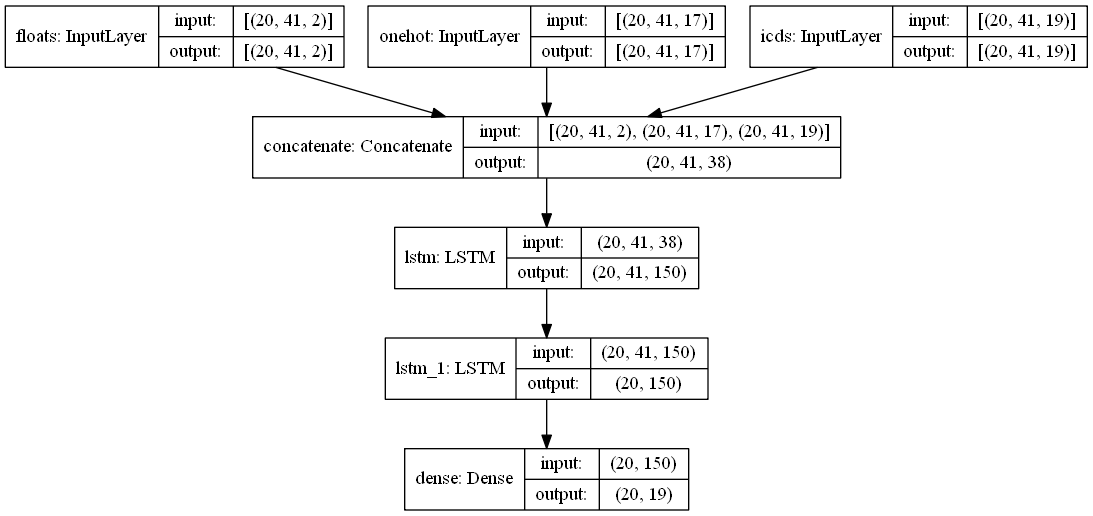

In [30]:
keras.utils.plot_model(model, "RNN for patient ICD prediction.png", show_shapes=True)

In [31]:
# this is the flexible learning rate scheduler
"""
----------- HYPERPARAMETERS -----------
the two variables express the number of epochs at which the change will start and the rate at which it decays
"""
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.02)

In [32]:
# RUN THIS AND BELOW TO GET A FRESH RUN
flexible_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [33]:
"""
----------- HYPERPARAMETERS -----------
epoch count recommended value is 200 with early stopping
learning rate multiplier rec. values are all between 0.1 and 4.0
"""
epochs = 200
lr_mult = 1.1

In [34]:
# True for softmax, False for sigmoid, automated

if output_activation == "sigmoid": logit_flag = False
else: logit_flag = True
if(logit_flag):
    threshold_value = 0.0
else:
    threshold_value = 0.5

In [35]:
"""
----------- HYPERPARAMETERS -----------
optimizer recommended: default Adam
"""

#opt = tf.keras.optimizers.SGD(learning_rate = 0.01)
#opt = tf.keras.optimizers.Adam()
#opt = tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.01, amsgrad=False)
opt = tf.keras.optimizers.Adam(learning_rate=0.01*lr_mult, amsgrad=True)
#opt = tf.keras.optimizers.SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True)

#opt = tfa.optimizers.MovingAverage(opt)

In [36]:
"""
----------- NOT EXACTLY HYPERPARAMETERS -----------
threshold values determine False and True positives and negatives that precision and recall are based off of
recommended values: between 0.20 and 0.80
"""
# at **11 it predicts all positives with an F1 0.025 - 0.026 (4digit)
# **3 got .17 F! as 3digit
threshold_value = 0.1**1
threshold_value = 0.27

In [37]:
# finally, we compile our network
"""
----------- HYPERPARAMETERS -----------
loss function should be BCE, but maybe try these in the future (Hinge, Focal, Jaccard)
loss label smoothing: between 0.0 and 0.20
"""
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=logit_flag,label_smoothing=0.0),
    #loss=tf.keras.losses.Hinge(),
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #for one-hot representation (or multi-label)
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #for integer representation (or multi-class which this isn't)
    optimizer=opt,
    metrics=["accuracy",
             tfa.metrics.HammingLoss(mode="multilabel"),
             tf.keras.metrics.Recall(thresholds = threshold_value),
             tf.keras.metrics.Precision(thresholds = threshold_value),
             #tf.keras.metrics.AUC(curve='PR', multi_label=False), # THIS SHOULD BE TRUE, ALSO FROM_LOGITS SHOULD BE SET
             tf.keras.metrics.AUC(multi_label=False), # THIS SHOULD BE TRUE, ALSO FROM_LOGITS SHOULD BE SET
             tf.keras.metrics.CategoricalAccuracy(),
             tf.keras.metrics.TruePositives(thresholds = threshold_value),
             tf.keras.metrics.TrueNegatives(thresholds = threshold_value),
             tf.keras.metrics.FalsePositives(thresholds = threshold_value),
             tf.keras.metrics.FalseNegatives(thresholds = threshold_value),
             tfa.metrics.F1Score(num_classes=icd_output_length,threshold = threshold_value),
            ],
    run_eagerly=True
)

In [38]:
# sets random state to be used in network setup
random_state = np.random.randint(0,1000+1)
random_state

534

In [39]:
# sets time variable for log names
now = datetime.now()
logname = now.strftime(' %d %B %Y - %H;%M;%S') # can't use ':' for some reason
csv_logger = CSVLogger('logs/00 training' + logname + ' - ' + data_aggr + '.csv', append=True) # need append otherwise it deletes old logs

In [40]:
# creates run hyperparameters log
with open('logs/01 training hyperparameters' + logname + ' - ' + data_aggr + '.txt', 'w') as f:
    p=''
    if(padding_after == 1): p ='after'
    else: p='before'
    f.write('data aggregation = ' + data_aggr + '\npadding = '+ p + '\n1st layer neurons = '+ str(first_layer_neurons) + '\n2nd layer neurons = ' + str(second_layer_neurons) + '\nepochs = ' + str(epochs) + '\nbatch size = ' + str(batch_size) + '\ntesting units = ' + str(testing_units) +  '\nthreshold value = ' + str(threshold_value) + '\ninstances read = ' + str(data_max_read) + '(data sample size = ' + str(data_sample_size) + ')' + '\noptimizer = ' + str(model.optimizer.get_config()) + '\nrandom state = ' + str(random_state))
    f.close()

In [41]:
# just a print
print(data_aggr)

categorical


In [42]:
# set this to 1 and input weight name file if you wish to load weights to the network
if(0):
    print('Weights loaded...')
    model.load_weights(' 04 March 2023 - 15;35;41 - 3digit weights 95.h5')

In [43]:
# HERE IT IS! WE RUN THE NETWORK!
# 1. save network weights
# 2. save HP setup in universal log file
# 3. start first epoch, not hyperparamets to set here
x = train_test_split(input_ready_floats, input_ready_onehot, input_ready_icds, output_ready_icds,
                     test_size=testing_units, random_state = random_state, shuffle=True)
[i_floats_train, i_floats_test, i_onehot_train, i_onehot_test, i_icds_train, i_icds_test, o_icds_train, o_icds_test] = x
model.save_weights(logname + ' - ' + data_aggr  + ' weights ' +str(random_state)+ '.h5')
with open('universal training log.csv', 'a') as f:
    p=''
    if(padding_after == 1): p ='after'
    else: p='before'
    f.write('\n' +logname+': data aggregation = ' + data_aggr + ', padding = '+ p + ', 1st layer neurons = '+ str(first_layer_neurons) + ', 2nd layer neurons = ' + str(second_layer_neurons) + ', epochs = ' + str(epochs) + ', batch size = ' + str(batch_size) + ', testing units = ' + str(testing_units) + ', instances read = ' + str(data_max_read) + '(data sample size = ' + str(data_sample_size) + ')' + ', optimizer = ' + str(model.optimizer.get_config()) + ', random state: ' +str(random_state))
    f.close()
history = tf.keras.callbacks.History()
history = model.fit(
    initial_epoch = 0,
    x = [i_floats_train,i_onehot_train,i_icds_train],
    y = o_icds_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = ([i_floats_test,i_onehot_test,i_icds_test], o_icds_test),
    shuffle=True,
    verbose=1,
    callbacks=[flexible_lr,
               csv_logger,
               UniversalLog(),
               #LossAndErrorPrintingCallback(),
               DifferencePrint(),
               #EarlyStoppingAtMinLoss2(),
               #tensorboard_callback,
               #EMAweightswap(),
               model_checkpoint_callback
              ],
)

Train on 6192 samples, validate on 688 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.010999999940395355.
Epoch 1/200
6192/6192 [==============================] - 63s 10ms/sample - loss: 0.5378 - accuracy: 0.7128 - hamming_loss: 0.3409 - recall: 0.8889 - precision: 0.5303 - auc: 0.7929 - categorical_accuracy: 0.0202 - true_positives: 39862.0000 - true_negatives: 37495.0000 - false_positives: 35310.0000 - false_negatives: 4981.0000 - f1_score: 0.4536 - val_loss: 0.5281 - val_accuracy: 0.7115 - val_hamming_loss: 0.3390 - val_recall: 0.8361 - val_precision: 0.5445 - val_auc: 0.7876 - val_categorical_accuracy: 0.0203 - val_true_positives: 4121.0000 - val_true_negatives: 4696.0000 - val_false_positives: 3447.0000 - val_false_negatives: 808.0000 - val_f1_score: 0.4012

Epoch 00002: LearningRateScheduler reducing learning rate to 0.010999999940395355.
Epoch 2/200
6180/6192 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.7154 - hamming_loss: 0.3

KeyError: 'val_accuracy'

In [ ]:
# once done, save history var to pd.DataFrame
hist_df = pd.DataFrame(history.history)
# or save to csv: 
hist_csv_file = 'history' + logname + ' - ' + data_aggr + '.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

END OF PROGRAM